In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)


import logging
tf.get_logger().setLevel(logging.ERROR)

# Data augmentation

In [6]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=30,var1_u=60,CROP1=CROP,BATCH_SIZE=10)

In [7]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

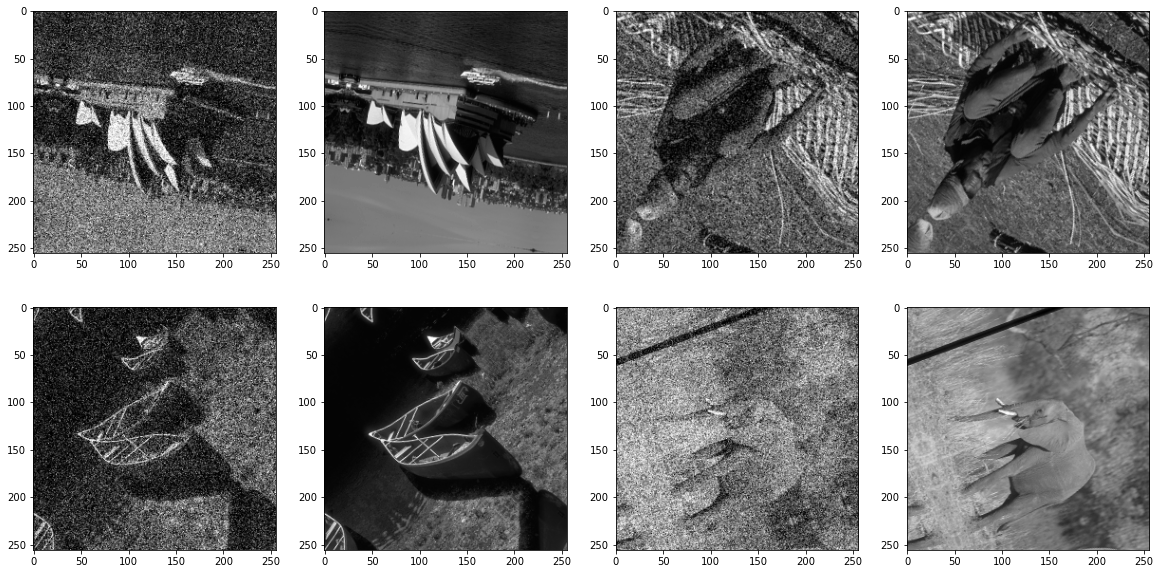

In [8]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        #axs[i,2*j].set_title(str(np.mean(xs[_])))
        
plt.show()

# Training

In [9]:
class losses:
    def Linfty(y_true,y_pred):
        error = tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(y_true-y_pred))))
        return error

    def W1infty(y_true,y_pred):
        error = tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(y_true-y_pred))))

        dx_true,dy_true = tf.image.image_gradients(y_true)
        dx_pred,dy_pred = tf.image.image_gradients(y_pred)

        error += tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(dx_true-dx_pred))))
        error += tf.math.log(tf.math.reduce_mean(tf.exp(tf.abs(dy_true-dy_pred))))


        return error

    def H1(y_true,y_pred):
        error = tf.math.reduce_mean(tf.pow(y_true-y_pred,2))

        dx_true,dy_true = tf.image.image_gradients(y_true)
        dx_pred,dy_pred = tf.image.image_gradients(y_pred)

        error += tf.math.reduce_mean(tf.pow(dx_true-dx_pred,2))
        error += tf.math.reduce_mean(tf.pow(dy_true-dy_pred,2))
        error = tf.sqrt(error)

        return error

    def L2(y_true,y_pred):
        error = tf.math.reduce_mean(tf.pow(y_true-y_pred,2))  

        return error
    
    def probability(y_true,y_pred):
        error = -tf.image.ssim(y_true,y_pred,1)

        return error


losses_names = ['Linfty','W1infty','H1','L2','probability']



In [10]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=10)

for loss in losses_names:
    print(loss)
    order = 1
    for num_classes in [5,10,15,20,50]:
        print('num_classes: ',num_classes)
        model = get_model("flux",it_lim=1,image_size=image_size,num_classes = num_classes)
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                loss=getattr(losses,loss))

        callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath= f"./checkpoints/flux{loss}tt_{typ}_{num_classes}",
        save_weights_only=True,
        verbose = True,
        save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5)
        ]

        history = model.fit(
            gen_batch_train,
            epochs=50,
            steps_per_epoch=30,
            validation_data=gen_batch_val,
            validation_steps=10,
            shuffle=False,
            use_multiprocessing=True,
            callbacks=callbacks,
            workers=1
        )

        np.save(f'./history/flux{loss}tt_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))

        

Linfty
num_classes:  5
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.0611
Epoch 1: val_loss improved from inf to 0.04836, saving model to ./checkpoints/fluxLinftytt_gaussian_5
30/30 [==============================] - 39s 1s/step - loss: 0.0611 - val_loss: 0.0484 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.0515
Epoch 2: val_loss did not improve from 0.04836
30/30 [==============================] - 33s 1s/step - loss: 0.0515 - val_loss: 0.0489 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 0.0478
Epoch 3: val_loss improved from 0.04836 to 0.04338, saving model to ./checkpoints/fluxLinftytt_gaussian_5
30/30 [==============================] - 34s 1s/step - loss: 0.0478 - val_loss: 0.0434 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: 0.0461
Epoch 4: val_loss did not improve from 0.04338
30/30 [==============================] - 35s 1s/step - loss: 0.0461 - val_l

30/30 [==============================] - ETA: 0s - loss: 0.0430
Epoch 34: val_loss did not improve from 0.03864
30/30 [==============================] - 32s 1s/step - loss: 0.0430 - val_loss: 0.0432 - lr: 8.0000e-06
Epoch 35/50
30/30 [==============================] - ETA: 0s - loss: 0.0427
Epoch 35: val_loss did not improve from 0.03864

Epoch 35: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
30/30 [==============================] - 32s 1s/step - loss: 0.0427 - val_loss: 0.0450 - lr: 8.0000e-06
Epoch 36/50
30/30 [==============================] - ETA: 0s - loss: 0.0418
Epoch 36: val_loss did not improve from 0.03864
30/30 [==============================] - 32s 1s/step - loss: 0.0418 - val_loss: 0.0415 - lr: 1.6000e-06
Epoch 37/50
30/30 [==============================] - ETA: 0s - loss: 0.0440
Epoch 37: val_loss did not improve from 0.03864
30/30 [==============================] - 32s 1s/step - loss: 0.0440 - val_loss: 0.0417 - lr: 1.6000e-06
Epoch 38/50
30/30 [==

FileNotFoundError: [Errno 2] No such file or directory: './history/fluxLinftytt_gaussian_5.npy'

In [ ]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=10)

for loss in losses_names:
    print(loss)
    order = 1
    for num_classes in [5,10,15,20,50]:
        print('num_classes: ',num_classes)
        model = get_model("flux",it_lim=1,image_size=image_size,num_classes = num_classes,
                         with_embedding = False, boundary_detector=False)
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                loss=getattr(losses,loss))

        callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath= f"./checkpoints/flux{loss}ff_{typ}_{num_classes}",
        save_weights_only=True,
        verbose = True,
        save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5)
        ]

        history = model.fit(
            gen_batch_train,
            epochs=50,
            steps_per_epoch=30,
            validation_data=gen_batch_val,
            validation_steps=10,
            shuffle=False,
            use_multiprocessing=True,
            callbacks=callbacks,
            workers=1
        )

        np.save(f'./history/flux{loss}ff_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
